# Lab 1: Multi-armed Bandits

This lab explores the multi-armed bandit problem, where an agent must choose among multiple options (arms) with unknown reward distributions to maximize its cumulative reward over time.

In [5]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

# %pylab inline

In [6]:
# Number of bandit arms
K = 5 # @param {"type":"integer"}
# Number of trials (time steps)
T = 100  # @param {"type":"integer"}

# Random seed
seed = 0

Text(0.5, 1.02, 'Unknown Reward Distributions for K Bandits')

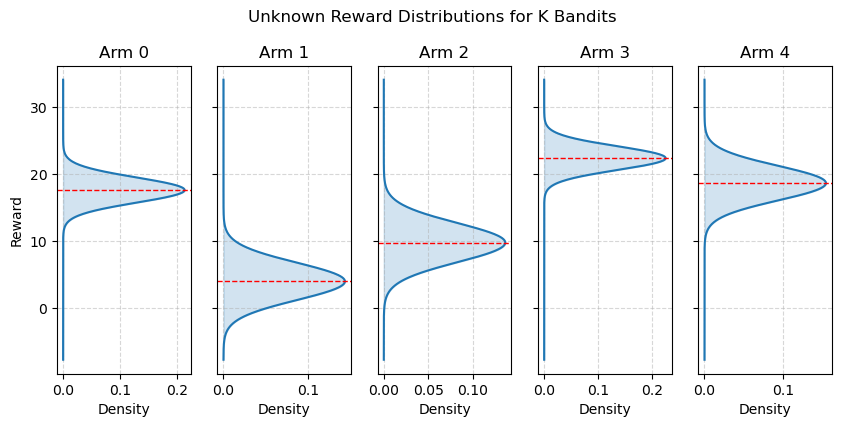

In [7]:
# Stattionary probability distribution for K bandits
np.random.seed(seed)
bandit_mean = 10 * np.random.normal(size=K)
bandit_std = np.random.uniform(1, 3, size=K)




###### Plot disttributions #######
fig, axes = plt.subplots(1, K, figsize=(2*K, 4), sharey=True)

x_min = bandit_mean.min() - 4 * bandit_std.max()
x_max = bandit_mean.max() + 4 * bandit_std.max()
x = np.linspace(x_min, x_max, 500)

for i, ax in enumerate(axes):
    y = norm.pdf(x, loc=bandit_mean[i], scale=bandit_std[i])
    ax.plot(y, x, color="C0")  # vertical orientation
    ax.fill_betweenx(x, 0, y, alpha=0.2, color="C0")
    ax.axhline(bandit_mean[i], color="r", linestyle="--", linewidth=1)  # mean
    ax.set_title(f"Arm {i}")
    ax.set_xlabel("Density")
    if i == 0:
        ax.set_ylabel("Reward")
    ax.grid(True, linestyle="--", alpha=0.5)
plt.suptitle("Unknown Reward Distributions for K Bandits", y=1.02)


Text(0, 0.5, 'Reward')

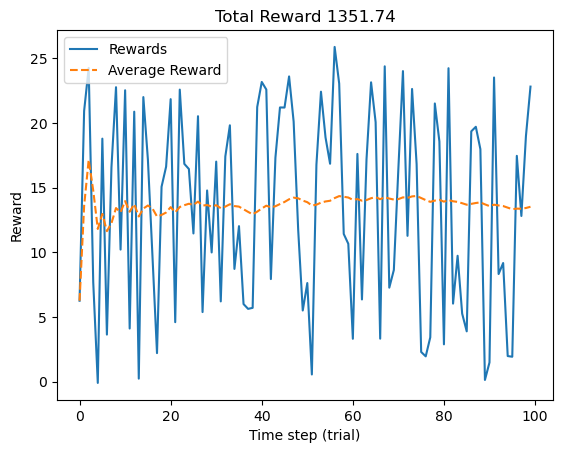

In [61]:
# Rewards
rewards = []

# For T trials, chose a random arm
for t in range(T):
  # Action: Choose a random arm
  a = np.random.randint(0, K-1)

  # Reward
  r = np.random.normal(bandit_mean[a], bandit_std[a])
  rewards.append(r)


# Total reward
total = sum(rewards)
avg_reward = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)

# Plot results
plt.plot(rewards, label='Rewards')
plt.plot(avg_reward, '--', label='Average Reward')
plt.legend()
plt.title("Rewards")
plt.title("Total Reward %.2f"%total)
plt.xlabel("Time step (trial)")
plt.ylabel("Reward")




## Exercise 1: Implement Your Own Bandit Policy

In the previous cells, we simulated a multi-armed bandit problem and observed the rewards obtained by choosing arms randomly. While this gives us a baseline, a random policy is unlikely to be the most effective way to maximize rewards.

Your task is to implement your own policy for selecting which bandit arm to pull at each time step `t`. The total reward should be higher than the

Text(0, 0.5, 'Reward')

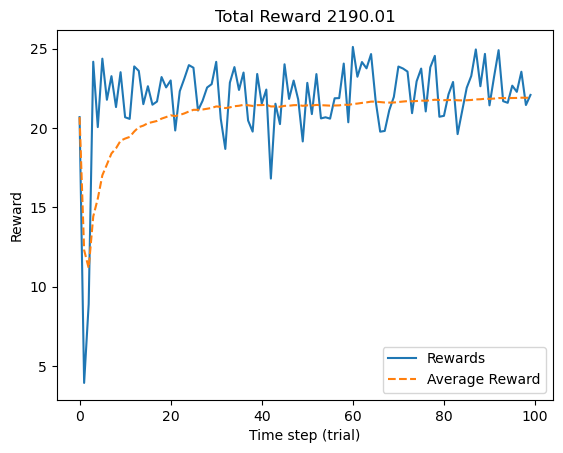

In [72]:
# Rewards
rewards = []
Q = np.zeros(K)      # estimated mean reward per arm
N = np.zeros(K, int) # pulls per arm

# For T trials, chose a random arm
for t in range(T):
  # Action: Choose a random arm

    if t < K:
        a = t
    else:
        a = np.argmax(Q)  # <-- GREEDY action

    # Reward
    r = np.random.normal(bandit_mean[a], bandit_std[a])
    rewards.append(r)

    # Incremental mean update for arm a
    N[a] += 1
    Q[a] += (r - Q[a]) / N[a]

# Total reward
total = sum(rewards)
avg_reward = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)

# Plot results
plt.plot(rewards, label='Rewards')
plt.plot(avg_reward, '--', label='Average Reward')
plt.legend()
plt.title("Rewards")
plt.title("Total Reward %.2f"%total)
plt.xlabel("Time step (trial)")
plt.ylabel("Reward")



## Exercise 2: Greedy strategy


1. Implement the greedy strategy: Always choose the arm with the highest estimated average reward.

2. Implement the Epsilon-greedy strategy: with a small probability epsilon, choose a random arm; otherwise, choose the greedy arm.

3. [Optional for 337] Implement Thompson Sampling: Maintain a probability distribution over the expected reward for each arm and sample from these distributions to choose an arm.



In [78]:
def plot_rewards(rewards, title_prefix):
    total = rewards.sum()
    avg = np.cumsum(rewards) / np.arange(1, len(rewards)+1)
    plt.figure()
    plt.plot(rewards, label='Reward')
    plt.plot(avg, '--', label='Avg reward')
    plt.legend()
    plt.xlabel('Time step')
    plt.ylabel('Reward')
    plt.title(f'{title_prefix} | Total = {total:.2f}')
    plt.grid()
    plt.show()


#### 1) Greedy Strategy

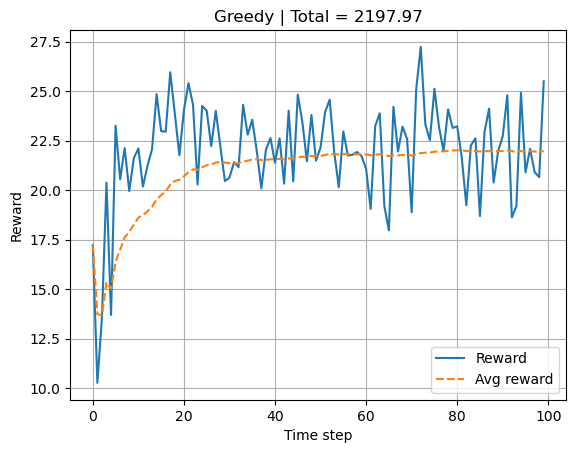

In [79]:
def run_greedy(K, T, bandit_mean, bandit_std):
    Q = np.zeros(K)          # estimated mean per arm
    N = np.zeros(K, int)     # pulls per arm
    rewards = []

    for t in range(T):
        # try each arm once, then purely greedy forever
        a = t if t < K else np.argmax(Q)

        r = np.random.normal(bandit_mean[a], bandit_std[a])
        rewards.append(r)

        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]   # incremental mean

    return np.array(rewards)

r1 = run_greedy(K, T, bandit_mean, bandit_std)
plot_rewards(r1, 'Greedy')

#### 2) Epsilon Greedy Strategy

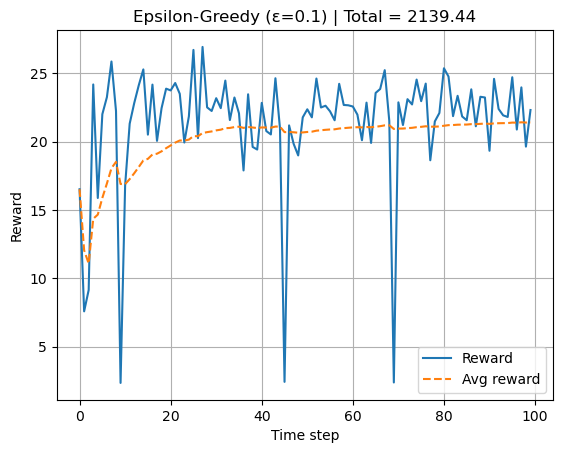

In [80]:
def run_epsilon_greedy(K, T, bandit_mean, bandit_std, eps=0.1):
    Q = np.zeros(K)
    N = np.zeros(K, int)
    rewards = []

    for t in range(T):
        if t < K:
            a = t                    # ensure every arm seen once
        else:
            a = np.random.randint(K) if np.random.rand() < eps else np.argmax(Q)

        r = np.random.normal(bandit_mean[a], bandit_std[a])
        rewards.append(r)

        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

    return np.array(rewards)

r2 = run_epsilon_greedy(K, T, bandit_mean, bandit_std, eps=0.1)
plot_rewards(r2, 'Epsilon-Greedy (ε=0.1)')

#### 3) Thompson Sampling

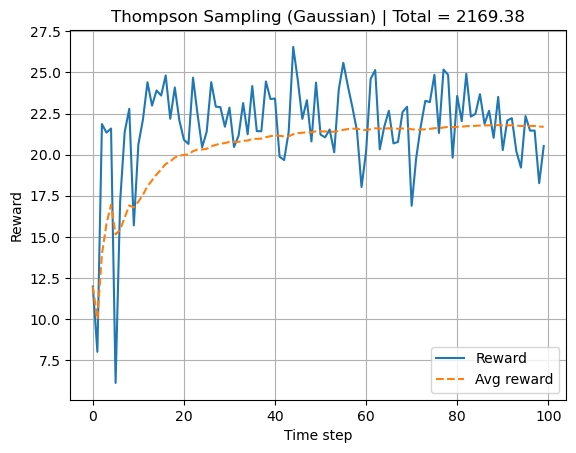

In [81]:
def run_thompson_sampling(K, T, bandit_mean, bandit_std, mu0=0.0, sigma0=1e3):
    # Large sigma0 ⇒ weakly-informative prior
    counts = np.zeros(K, int)
    sums   = np.zeros(K, float)
    rewards = []

    prior_var = sigma0**2
    obs_var   = bandit_std**2  # per-arm known variances

    for t in range(T):
        # sample one sigma per arm from its current posterior
        thetas = np.empty(K)
        for a in range(K):
            n = counts[a]
            if n == 0:
                post_var  = prior_var
                post_mean = mu0
            else:
                # posterior precision = prior_prec + n / obs_var
                prior_prec = 1.0 / prior_var
                obs_prec   = 1.0 / obs_var[a]
                post_prec  = prior_prec + n * obs_prec
                post_var   = 1.0 / post_prec
                sample_mean = sums[a] / n
                post_mean = post_var * (mu0 * prior_prec + n * sample_mean * obs_prec)

            thetas[a] = np.random.normal(post_mean, np.sqrt(post_var))

        a = int(np.argmax(thetas))

        r = np.random.normal(bandit_mean[a], bandit_std[a])
        rewards.append(r)

        counts[a] += 1
        sums[a]   += r

    return np.array(rewards)

r3 = run_thompson_sampling(K, T, bandit_mean, bandit_std)
plot_rewards(r3, 'Thompson Sampling (Gaussian)')

# Questions
After compleing the excercises, answer the following questions:

1. In the epsilon-greedy strategy, compare ε = 0.1 and ε = 0.001. What are the advantages of using a larger ε?
2. If the reward distribution changes smoothly over time, is a purely greedy strategy still effective?
3. How does the choice of ε affect the balance between exploration and exploitation in the long run?  
4. Suppose the number of arms increases significantly. How might this change the effectiveness of the epsilon-greedy strategy?  

# Answers to the Questions

#### 1) In the epsilon-greedy strategy, compare ε = 0.1 and ε = 0.001. What are the advantages of using a larger ε?
- **Larger ε (0.1):** more exploration and faster discovery of good arms, lower chance of getting stuck on a bad arm, better adaptation if rewards drift.
- **Smaller ε (0.001):** almost always exploits, higher steady-state reward if the best arm is already identified

#### 2) If rewards change smoothly over time, is pure greedy effective?
- **No.** Pure greedy stops exploring and adapts poorly to drift.
- Use:
  - ε-greedy with a **non-zero floor** (ε_min > 0),
  - **constant step-size**/discounted updates (forget old data)
  - algorithms for non-stationarity (Thompson Sampling).

#### 3) How does ε affect exploration–exploitation in the long run?
- **Larger ε:** continual exploration, robust to changes but*lower asymptotic average reward (keep taking random actions).
- **Smaller ε:** faster convergence and higher asymptotic reward if correct, but greater risk of locking onto a suboptimal arm.

#### 4) If the number of arms \(K\) grows a lot, what happens to ε-greedy?
- With fixed ε, each arm is sampled with probability **ε/K**  exploration is weak and learning slows.
- **Mitigations:**
  - force a few initial pulls per arm
  - scale ε with \(K\) or time
